In [16]:
'''
/***************************************************************************************
*    Title: Item Response Theory in Python
*    Author: unknown
*    Date: Mar 14, 2019
*    Code version: irt 0.0.2
*    Availability: https://pypi.org/project/irt/
*
***************************************************************************************/
'''

'\n/***************************************************************************************\n*    Title: Item Response Theory in Python\n*    Author: unknown\n*    Date: Mar 14, 2019\n*    Code version: irt 0.0.2\n*    Availability: https://pypi.org/project/irt/\n*\n***************************************************************************************/\n'

In [1]:
from builtins import range
from numpy import (abs, array, concatenate, copy, exp, inf, log, log1p, max,
                   newaxis, sort, sum)
from scipy.optimize import minimize
from scipy.stats import dirichlet, lognorm, norm
from scipy.special import expit
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
# Scale parameters for the a-priory distribution of parameters -
# The standard deviation of theta (student ability)
THETA_SCALE = 1.
# The standard deviation of beta (item difficulty)
BETA_SCALE = 1.

In [3]:
# Parameters are initialized as the avg. of a large number of parameters
# which are randomly generated, how large should this number be?
INITIAL_PARAMETER_AVG = 100

# When scipy.optimize minimization fails with these messages, we can
# expect the result reached to still be pretty good
OPTIMIZE_MAX_REACHED_MSG = ['Maximum number of iterations has been exceeded.',
                            'Maximum number of function evaluations '
                            'has been exceeded.']
# Method parameter for scipy.optimize.minimize
MINIMIZATION_METHOD = 'Nelder-Mead'

# Bound on the number of MLE iterations
MAX_ITER = 100
# If no parameters has changed by more than DIFF in the last SMALL_DIFF_STREAK
# iterations, then we terminate the optimization process
DIFF = 0.001
SMALL_DIFF_STREAK = 3

In [4]:
def logistic(a):
    return expit(a)
    #return 1./(1+np.exp(-a))

In [5]:
def base_irt_model(beta, theta):
    return expit(theta - beta)

In [6]:
class StudentParametersDistribution(object):
    """
    An object for generation and calculation of student parameters.
    """
    def __init__(self, theta_scale=THETA_SCALE):
        self.theta = norm(loc=0., scale=theta_scale)

    # This part randomly produce some randome values base on the distribution defined above
    # It creates randome values based on the number of students
    def rvs(self, size=None):
        return self.theta.rvs(size)

    def logpdf(self, theta):
        return self.theta.logpdf(theta)


class QuestionParametersDistribution(object):
    """
    An object for generation and calculation of question parameters.
    """
    def __init__(self, beta_scale=BETA_SCALE):
        self.beta = norm(loc=0., scale=beta_scale)

    # This part randomly produce some randome values base on the distribution defined above
    # It creates randome values based on the number of subquestions
    def rvs(self, size=None):
        return self.beta.rvs(size)

    def logpdf(self, beta):
        return self.beta.logpdf(beta)

In [7]:
def initialize_random_values(students_count, subquestions_count,
                             student_dist, question_dist):
    theta_values = sum(student_dist.rvs(size=(INITIAL_PARAMETER_AVG,
                                              students_count)),
                       axis=0) / INITIAL_PARAMETER_AVG
    beta_values = sum(question_dist.rvs(size=(INITIAL_PARAMETER_AVG,
                                              subquestions_count)),
                      axis=0) / INITIAL_PARAMETER_AVG
    return theta_values, beta_values

## What is this doing?????
# This is were we handle continuous variables so we need to look more here for continuous values
def expanded_scores(score_matrix):
    answers = [list(set(score)) for score in score_matrix]
    subscores = []
    for i, question_scores in enumerate(score_matrix):
        best = len(answers[i])
        subscores_per_student = []
        for student_score in question_scores:
            expanded = [1] * answers[i].index(student_score)
            if len(expanded) < best - 1:
                expanded = expanded + [-1]
                expanded = expanded + [0] * (best - 1 - len(expanded))
            subscores_per_student.append(expanded)
        subscores.append(array(subscores_per_student).T)
    return concatenate(subscores)

def initialize_estimation(scores, student_dist, question_dist):
    # Even though we usually input the table as scores per student,
    # the analysis is easier for a table of scores per question:
    scores = scores.T
    questions_count, students_count = scores.shape
    # Split each question into small sub-question.
    
    # This part gets the different answers for a certain question
    answers_per_question = [sort(array(list(set(score)))) for score in scores]
    # This part counts how many different answer there are for a certain question
    subquestions_per_question = [len(answers) for answers in answers_per_question]
    # This part counts the total number of subquestions
    subquestions_count = sum(subquestions_per_question) - questions_count
    # Begin with small random values per parameter to break symmetry.
    thetas, betas = initialize_random_values(students_count,
                                             subquestions_count,
                                             student_dist, question_dist)
    # Modify the question array according to those new sub-questions.
    expanded = expanded_scores(scores)
    return expanded, thetas, betas

In [8]:
def parse_optimization_result(res):
    """
    Modify the dictionary returned by scipy.optimize.minimize to get the
    actual optimal value of `x` obtained by the minimization process.
    """
    if not res['success'] and res['message'] not in OPTIMIZE_MAX_REACHED_MSG:
        raise RuntimeError("Optimization failed:\n" + repr(res))
    return res['x']


def learn_beta(thetas, question_dist, corrects):
    """
    Returns a function that can calculate the log-likelihood of question
    parameters given thetas and answers of different students.

    Returns an estimation function suitable for optimization.
    """
    def f(arg):
        b = arg
        mult = question_dist.logpdf(b)
        p = base_irt_model(b, thetas)
        for i, correct in enumerate(corrects):
            # correct answer is 1, incorrect by -1, no answer is 0
            # multiply by a factor of 2 per student, to utilize log1p
            mult += log1p((2 * p[i] - 1) * correct)
        return -mult
    return f

def question_beta_given_theta(thetas, question_dist, scores, initial_beta):
    """
    find the maximal-likelihood question parameters, given the ability
    and answers of all students, for a single question
    """
    to_minimize = learn_beta(thetas, question_dist, scores)
    res = minimize(to_minimize, initial_beta, method=MINIMIZATION_METHOD)
    return parse_optimization_result(res)


def all_betas_given_theta(thetas, question_dist, scores, betas):
    """
    find the maximal-likelihood question parameters, given the ability
    and answers of all students, for all questions question
    """
    return array([question_beta_given_theta(thetas, question_dist, scores[i], betas[i])
                  for i in range(len(betas))])

def learn_theta(betas, student_dist, corrects):
    """
    Returns a function that can calculate the log-likelihood of student
    parameters given question parameters and answers of different
    students.

    Returns an estimation function suitable for optimization.
    """
    def f(theta):
        theta = theta[0]
        mult = student_dist.logpdf(theta)
        b = betas
        p = base_irt_model(b, theta)
        for i, correct in enumerate(corrects):
            mult += log1p((2 * p[i] - 1) * correct)
        return -mult
    return f

def student_theta_given_beta(betas, student_dist, scores, inital_theta):
    """
    find the maximal-likelihood ability parameter of a single student,
    given his answers and the parameters of the questions
    """
    to_minimize = learn_theta(betas, student_dist, scores)
    res = minimize(to_minimize, [inital_theta], method=MINIMIZATION_METHOD)
    return parse_optimization_result(res)


def all_thetas_given_beta(betas, student_dist, scores, thetas):
    """
    find the maximal-likelihood ability parameter of a all students,
    given their answers and the parameters of the questions
    """
    return array([student_theta_given_beta(betas, student_dist, scores[:, i], thetas[i])
                  for i in range(len(thetas))])

In [9]:
def estimate_thetas(scores, verbose=False):
    """
    Estimates the student theta (ability) and question parameters.

    Currently uses JMLE to simultaneously estimate the parameters for
    students and for questions.

    Parameters
    ----------
    scores : array_like
        A 2-dimensional array of question scores, where each row
        corresponds to a single student. Grades should be integers but
        their scale can be arbitrary (supports partial credit, not only
        0 and 1).

    """
    # The student and item difficutly is constructed in the random manner as a Gaussian Distribution
    student_dist = StudentParametersDistribution()
    question_dist = QuestionParametersDistribution()
    expanded, thetas, betas = initialize_estimation(scores, student_dist, question_dist)
    small_diffs_streak = 0
    iter_count = 0
    while iter_count < MAX_ITER and small_diffs_streak < SMALL_DIFF_STREAK:
        old_betas, old_thetas = copy(betas), copy(thetas)
        betas = all_betas_given_theta(thetas, question_dist, expanded, betas)
        thetas = all_thetas_given_beta(betas, student_dist, expanded, thetas)
        # How much have the parameters changed from last time?
        diff = max([max(abs(old_betas - betas)), max(abs(old_thetas - thetas))])
        if diff < DIFF:
            small_diffs_streak += 1
        else:
            small_diffs_streak = 0
        iter_count += 1
        #if verbose:
        #    print(diff)
    return thetas, betas

In [10]:
size = []
acc = []
theta_spearman = []
diff_spearman = []

theta_pearson = []
diff_pearson = []

for i in range(20,500,20):
    size.append(i)
    n_s = i # number of students
    n_i = i # number of items

    # pick a random ability for each student from an N(0,1) distribution

    abilities = np.random.randn(n_s,1)

    # pick a random difficulty for each item from an N(0,1) distribution

    difficulties = np.random.randn(1,n_i)

    # the IRT model says that P(correct[s,i]) = logistic(ability[s] -difficulty[i])
    prob_correct = logistic(abilities - difficulties) 

    # flip a coin to pick 'correct' or 'incorrect' for each student based on the
    # probability of a correct response

    student_responses = np.random.binomial(1,prob_correct)
    
    # This is the part where the student ability and the item difficulty is being trained
    # This estimation uses the four paremeter model
    thetas, betas = estimate_thetas(student_responses)

    # This is where we restore the responses with the obtained parameters
    prob_correct = base_irt_model(betas.T, thetas)

    prediction = np.random.binomial(1,prob_correct)
    for s in range(n_s):
        for i in range(n_i):
            if prob_correct[s][i] > 0.5:
                prediction[s][i] = 1
            else:
                prediction[s][i] = 0
    
    # This is where we test the restored responses again
    total_number_of_responses = n_s * n_i
    correct = 0
    for s in range(n_s):
        for i in range(n_i):
            if student_responses[s][i] == prediction[s][i]:
                correct += 1
    acc.append(correct/total_number_of_responses)
    
    correlation, p_value = spearmanr(abilities,thetas)
    theta_spearman.append(correlation)

    correlation, p_value = spearmanr(difficulties.flatten(),betas)
    diff_spearman.append(correlation)

    correlation, p_value = pearsonr(abilities.flatten(), thetas.flatten())
    theta_pearson.append(correlation)

    correlation, p_value = pearsonr(difficulties.flatten(),betas.flatten().T)
    diff_pearson.append(correlation)

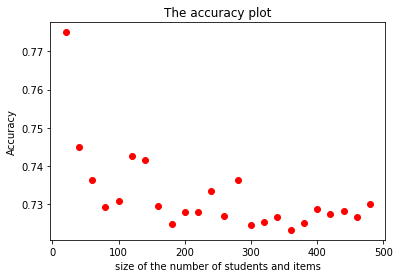

In [11]:
plt.title('The accuracy plot')
plt.xlabel('size of the number of students and items')
plt.ylabel('Accuracy')
plt.plot(size, acc,'ro')
plt.savefig('the_accuracy_plot.png')

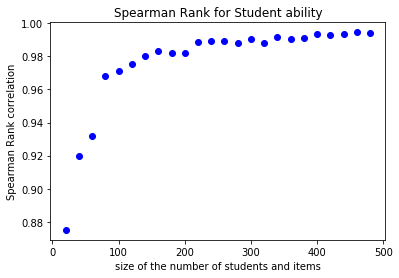

In [12]:
plt.title('Spearman Rank for Student ability')
plt.xlabel('size of the number of students and items')
plt.ylabel('Spearman Rank correlation')
plt.plot(size, theta_spearman,'bo')
plt.savefig('Spearman Rank for Student ability.png')

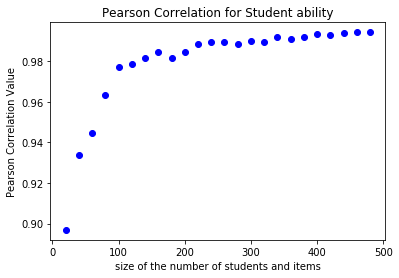

In [13]:
plt.title('Pearson Correlation for Student ability')
plt.xlabel('size of the number of students and items')
plt.ylabel('Pearson Correlation Value')
plt.plot(size, theta_pearson,'bo')
plt.savefig('Pearson Correlation for Student ability.png')

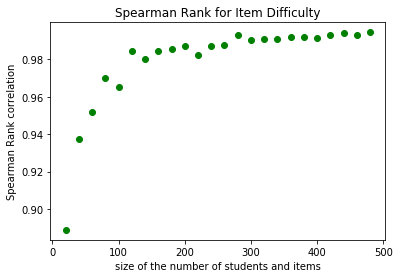

In [14]:
plt.title('Spearman Rank for Item Difficulty')
plt.xlabel('size of the number of students and items')
plt.ylabel('Spearman Rank correlation')
plt.plot(size, diff_spearman,'go')
plt.savefig('Spearman Rank for Item Difficulty.png')

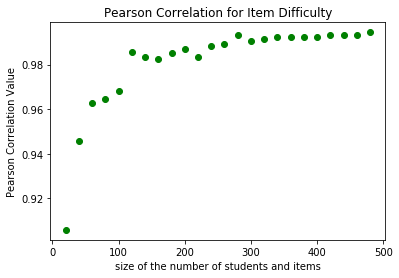

In [15]:
plt.title('Pearson Correlation for Item Difficulty')
plt.xlabel('size of the number of students and items')
plt.ylabel('Pearson Correlation Value')
plt.plot(size, diff_pearson,'go')
plt.savefig('Pearson Correlation for Item Difficulty.png')